In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
from functional import seq
from loguru import logger
from joblib import Parallel, delayed
from scipy.optimize import minimize

from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

config = {
    "font.family": "serif",
    "font.size": 12,
    "mathtext.fontset": "stix",  # matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
    "font.serif": ["STZhongsong"],  # 华文中宋
    "axes.unicode_minus": False  # 处理负号，即-号
}
rcParams.update(config)

In [10]:
import sys
sys.path.append(".")
sys.path.append("D:\Code\Mine\occupational_health_system_v2")
from staff_info import StaffInfo
from diagnose_info.auditory_diagnose import AuditoryDiagnose
from utils.data_helper import mark_group_name, filter_data
from Chinese_control_group_logistic_regression_0 import logistic_func as logistic_func_control_0
from Chinese_control_group_logistic_regression_1 import logistic_func as logistic_func_control_1
from Chinese_logistic_regression import logistic_func, log_likelihood, log_likelihood_new, userdefine_logistic_regression_plot

In [11]:
input_path = Path("./cache/Chinese_extract_experiment_classifier_df.csv")
models_path = Path("./models")
extract_df = pd.read_csv(input_path, header=0, index_col="staff_id")
duration_cut = [0, 4, 10, np.inf]
kurtosis_geomean_cut = [0, 10, 25, np.inf]
extract_df["duration_box_best"] = extract_df["duration"].apply(
    lambda x: mark_group_name(x, qcut_set=duration_cut, prefix="D-"))

In [16]:
def userdefine_logistic_regression_task(
        fit_df: pd.DataFrame,
        models_path: Path,
        model_name: str,
        y_col_name: str = "NIHL1234_Y",
        params_init: list = [
            -4.18049946, 0.07176393, 1.32653869, 2.13749184, 8.65684751, 3
        ],
        L_control_range: np.array = np.arange(70, 90),
        phi_range=None,
        **kwargs,
):
    """_summary_
    自定义逻辑回归函数

    Args:
        fit_df (pd.DataFrame): _description_
        models_path (Path): _description_
        model_name (str): _description_
        y_col_name (str, optional): _description_. Defaults to "NIHL1234_Y".
        params_init (list, optional): _description_. Defaults to [ -4.18049946, 0.07176393, 1.32653869, 2.13749184, 8.65684751, 3 ].
        L_control_range (np.array, optional): _description_. Defaults to np.arange(70, 90).
        phi_range
    """

    minimize_method = kwargs.pop(
        "minimize_method", "Nelder-Mead"
    )  #"SLSQP", #"Powell", #"L-BFGS-B", #"Nelder-Mead", #"BFGS",
    minimize_options = kwargs.pop("minimize_options", {'maxiter': 10000})
    minimize_bounds = kwargs.pop("minimize_bounds", None)

    log_likelihood_value = []
    params_estimated = []
    phi_estimated = []
    for L_control in L_control_range:
        work_df = fit_df.copy()
        work_df = pd.get_dummies(work_df, columns=["duration_box_best"])
        work_df["LAeq"] -= L_control
        work_df["LAeq"] /= work_df["LAeq"].max()
        work_df["duration_box_best_D-1"] *= work_df["LAeq"]
        work_df["duration_box_best_D-2"] *= work_df["LAeq"]
        work_df["duration_box_best_D-3"] *= work_df["LAeq"]

        y = work_df[y_col_name]
        X = work_df.drop(columns=[y_col_name, "LAeq"])
        # logger.info(f"minimize method: {minimize_method}")
        # logger.info(f"minimize bounds: {minimize_bounds}")
        if phi_range:
            for phi in phi_range:
                # logger.info(f"Fixed phi: {phi}")
                results = minimize(log_likelihood_new,
                                   params_init,
                                   args=(phi, X.values, y.values),
                                   method=minimize_method,
                                   options=minimize_options,
                                   bounds=minimize_bounds)
                log_likelihood_value.append(results.fun)
                params_estimated.append(results.x)
                phi_estimated.append(phi)
        else:
            results = minimize(log_likelihood,
                               params_init,
                               args=(X.values, y.values),
                               method=minimize_method,
                               options=minimize_options,
                               bounds=minimize_bounds)
            log_likelihood_value.append(results.fun)
            params_estimated.append(results.x)
        # logger.info(f"Fit result for L_control = {L_control}")
        # logger.info(f"Fit status: {results.success}")
        # logger.info(f"Log likehood: {round(results.fun,2)}")
        # logger.info(f"Iterations: {results.nit}")

    max_LAeq = extract_df["LAeq"].max()
    best_log_likelihood_value = np.min(log_likelihood_value)
    best_params_estimated = params_estimated[np.argmin(log_likelihood_value)]
    if phi_range:
        best_phi_estimated = phi_estimated[np.argmin(log_likelihood_value)]
        best_params_estimated = np.append(best_params_estimated,
                                          best_phi_estimated)
    best_L_control = L_control_range[np.argmin(log_likelihood_value)]
    logger.info(
        f"Final result: {seq(best_params_estimated).map(lambda x: round(x,4))} + {best_L_control}. \n Log likelihood: {round(best_log_likelihood_value,2)}"
    )

    pickle.dump([
        best_params_estimated, best_L_control, max_LAeq,
        best_log_likelihood_value
    ], open(models_path / Path(y_col_name + "-" + model_name), "wb"))
    return best_params_estimated, best_L_control, max_LAeq, best_log_likelihood_value

(2182, 4)


2024-06-12 15:10:25.597 | INFO     | __main__:userdefine_logistic_regression_task:82 - Final result: [-6.8902, 0.1186, 4.0, 5.0073, 6.3125, 3.0] + 62. 
 Log likelihood: 863.8
2024-06-12 15:10:25.600 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:248 - Params: [-6.89017944  0.11855276  4.          5.00733379  6.31247891  3.        ]
2024-06-12 15:10:25.600 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:249 - L_control: 62
2024-06-12 15:10:25.601 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:250 - max LAeq: 124.18425821657326
2024-06-12 15:10:25.602 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:261 - f prime: [2.24983209e-03 2.05949497e-03 1.69748236e-03 1.37231068e-03
 1.08309999e-03 8.29134161e-04 6.09847991e-04 4.24811855e-04
 2.73714564e-04 1.56344940e-04 7.25725267e-05 2.23277424e-05
 5.58170898e-06 2.23259293e-05 7.25519032e-05 1.56230717e-04
 2.73292574e-04 4.2

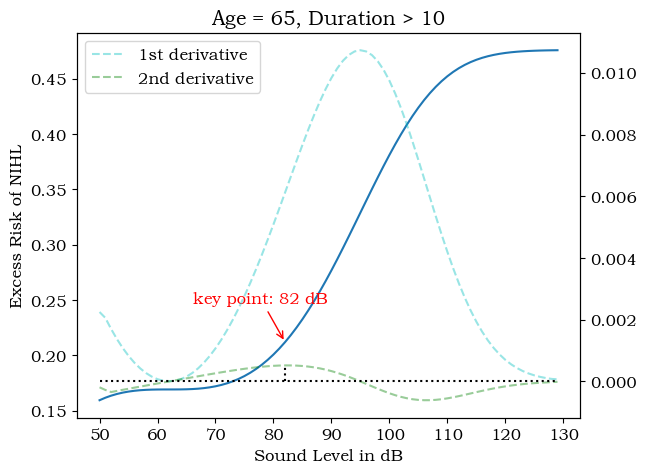

{50: 0.6836045223494659,
 51: 0.6858543544440419,
 52: 0.6877235122884393,
 53: 0.6892493191704344,
 54: 0.6904681336572206,
 55: 0.6914155191543329,
 56: 0.6921264019797598,
 57: 0.6926352151354281,
 58: 0.6929760256895479,
 59: 0.6931826442628164,
 60: 0.6932887155688245,
 61: 0.6933277893163029,
 62: 0.6933333710536085,
 63: 0.6933389527342558,
 64: 0.6933780229122692,
 65: 0.6934840565405944,
 66: 0.6936904843458727,
 67: 0.6940306416890512,
 68: 0.6945376966946757,
 69: 0.6952445572452345,
 70: 0.6961837561965148,
 71: 0.6973873138858107,
 72: 0.6988865766926008,
 73: 0.7007120300933213,
 74: 0.7028930843581672,
 75: 0.7054578308074976,
 76: 0.7084327664270933,
 77: 0.7118424846941963,
 78: 0.715709330758957,
 79: 0.7200530197365717,
 80: 0.7248902178781925,
 81: 0.7302340878893321,
 82: 0.7360938017326807,
 83: 0.7424740269508135,
 84: 0.749374395904294,
 85: 0.7567889713228537,
 86: 0.7647057261197938,
 87: 0.7731060603345322,
 88: 0.7819643830392294,
 89: 0.7912477916330889,
 9

In [25]:
fit_df = extract_df.query(
    "duration_box_best in ('D-1', 'D-2', 'D-3') and LAeq >= 70 and kurtosis_geomean <= 10"
)[["age", "LAeq", "duration_box_best", "NIHL1234_Y"]]
print(fit_df.shape)
userdefine_logistic_regression_task(
    fit_df=fit_df,
    models_path=models_path,
    model_name="KG_1_test-Chinese_experiment_group_udlr_model.pkl",
    y_col_name="NIHL1234_Y",
    params_init=[-3, 0.07, 2, 4, 8.65],
    L_control_range=np.arange(60, 80),
    phi_range=[3],
    minimize_bounds = ([None,None],[None,None],[1,4],[4,6],[6,9]))
best_params_estimated, best_L_control, max_LAeq, best_log_likelihood_value = pickle.load(
    open(
        models_path / Path(
            "NIHL1234_Y-KG_1_test-Chinese_experiment_group_udlr_model.pkl"),
        "rb"))
control_params_estimated_0, control_log_likelihood_value_0 = pickle.load(
    open(
        models_path /
        Path("NIHL1234_Y-Chinese_control_group_udlr_model_0.pkl"),
        "rb"))
userdefine_logistic_regression_plot(
    best_params_estimated=best_params_estimated,
    best_L_control=best_L_control,
    max_LAeq=max_LAeq,
    age=65,
    LAeq=np.arange(50, 130),
    duration=np.array([0, 0, 1]),
    point_type="2nd",
    control_params_estimated=control_params_estimated_0)

(1643, 4)


2024-06-12 15:09:55.463 | INFO     | __main__:userdefine_logistic_regression_task:82 - Final result: [-6.9034, 0.1255, 4.0, 5.3982, 6.0, 3.0] + 63. 
 Log likelihood: 651.51
2024-06-12 15:09:55.465 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:248 - Params: [-6.90343905  0.12551198  3.99999996  5.39823252  6.          3.        ]
2024-06-12 15:09:55.465 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:249 - L_control: 63
2024-06-12 15:09:55.466 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:250 - max LAeq: 124.18425821657326
2024-06-12 15:09:55.466 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:261 - f prime: [2.18155507e-03 2.00846001e-03 1.67884490e-03 1.38166766e-03
 1.11562525e-03 8.79646718e-04 6.72871617e-04 4.94627559e-04
 3.44407297e-04 2.21845448e-04 1.26695026e-04 5.88038439e-05
 1.80908544e-05 4.52245000e-06 1.80887456e-05 5.87798558e-05
 1.26562169e-04 2.213

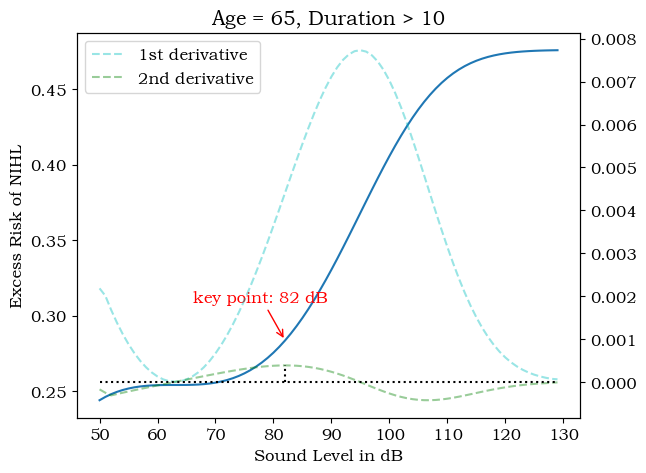

{50: 0.7680418936334241,
 51: 0.7702234487046569,
 52: 0.7720588136521433,
 53: 0.7735811385109224,
 54: 0.7748221489698457,
 55: 0.7758123890031485,
 56: 0.7765814424058334,
 57: 0.7771581322363781,
 58: 0.7775706975234751,
 59: 0.7778469468297414,
 60: 0.7780143884200822,
 61: 0.778100336881927,
 62: 0.778131996107816,
 63: 0.7781365185907678,
 64: 0.7781410410078182,
 65: 0.778172696081926,
 66: 0.7782586007194128,
 67: 0.7784258204201651,
 68: 0.7787013099513399,
 69: 0.7791118302632122,
 70: 0.7796838416103563,
 71: 0.7804433728273114,
 72: 0.7814158667031493,
 73: 0.782626001415977,
 74: 0.7840974880430028,
 75: 0.7858528442761082,
 76: 0.7879131446737323,
 77: 0.7902977480987878,
 78: 0.7930240034644626,
 79: 0.7961069355720061,
 80: 0.7995589137128671,
 81: 0.8033893068525554,
 82: 0.8076041306357348,
 83: 0.812205693154524,
 84: 0.8171922483830542,
 85: 0.8225576683456103,
 86: 0.828291147355529,
 87: 0.8343769538902203,
 88: 0.8407942476532005,
 89: 0.8475169808631426,
 90: 0

In [24]:
fit_df = extract_df.query(
    "duration_box_best in ('D-1', 'D-2', 'D-3') and LAeq >= 70 and kurtosis_geomean > 10 and kurtosis_geomean <= 25"
)[["age", "LAeq", "duration_box_best", "NIHL1234_Y"]]
print(fit_df.shape)
userdefine_logistic_regression_task(
    fit_df=fit_df,
    models_path=models_path,
    model_name="KG_2_test-Chinese_experiment_group_udlr_model.pkl",
    y_col_name="NIHL1234_Y",
    params_init=[-3, 0.07, 2, 4, 8.65],
    L_control_range=np.arange(60, 80),
    phi_range=[3],
    minimize_bounds = ([None,None],[None,None],[1,4],[4,6],[6,9]))
best_params_estimated, best_L_control, max_LAeq, best_log_likelihood_value = pickle.load(
    open(
        models_path / Path(
            "NIHL1234_Y-KG_2_test-Chinese_experiment_group_udlr_model.pkl"),
        "rb"))
control_params_estimated_0, control_log_likelihood_value_0 = pickle.load(
    open(
        models_path /
        Path("NIHL1234_Y-Chinese_control_group_udlr_model_0.pkl"),
        "rb"))
userdefine_logistic_regression_plot(
    best_params_estimated=best_params_estimated,
    best_L_control=best_L_control,
    max_LAeq=max_LAeq,
    age=65,
    LAeq=np.arange(50, 130),
    duration=np.array([0, 0, 1]),
    point_type="2nd",
    control_params_estimated=control_params_estimated_0)

2024-06-12 15:09:04.432 | INFO     | __main__:userdefine_logistic_regression_task:82 - Final result: [-5.3414, 0.096, 3.5464, 4.3588, 6.0, 3.0] + 62. 
 Log likelihood: 344.92
2024-06-12 15:09:04.434 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:248 - Params: [-5.34136328  0.09596103  3.54639355  4.35882129  6.          3.        ]
2024-06-12 15:09:04.434 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:249 - L_control: 62
2024-06-12 15:09:04.435 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:250 - max LAeq: 124.18425821657326
2024-06-12 15:09:04.435 | INFO     | Chinese_logistic_regression:userdefine_logistic_regression_plot:261 - f prime: [2.07138278e-03 1.89602147e-03 1.56254454e-03 1.26309350e-03
 9.96820813e-04 7.63039323e-04 5.61208251e-04 3.90917430e-04
 2.51870228e-04 1.43865569e-04 6.67793298e-05 2.05453319e-05
 5.13611752e-06 2.05436082e-05 6.67597233e-05 1.43756979e-04
 2.51469047e-04 3.8

(651, 4)


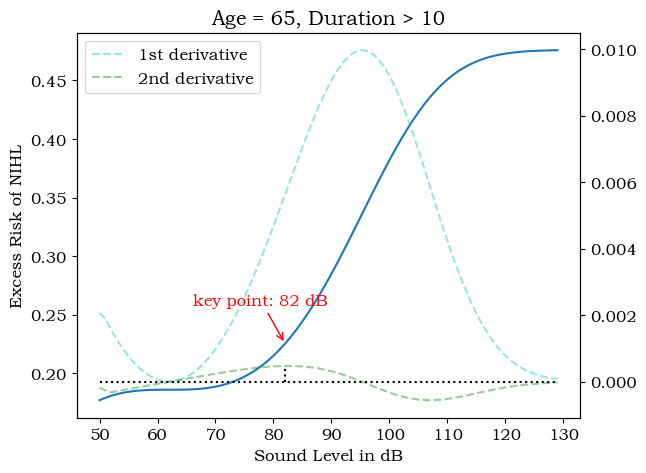

{50: 0.7011931399789869,
 51: 0.7032645227564297,
 52: 0.7049851829217082,
 53: 0.706389611842296,
 54: 0.7075113699237534,
 55: 0.7083832534691291,
 56: 0.7090374485689805,
 57: 0.7095056699719681,
 58: 0.7098192834287664,
 59: 0.7100094104270722,
 60: 0.7101070145674364,
 61: 0.7101429690867485,
 62: 0.7101481052312023,
 63: 0.710153241321792,
 64: 0.7101891924476589,
 65: 0.7102867607683249,
 66: 0.7104767064058989,
 67: 0.7107896988631425,
 68: 0.7112562488137378,
 69: 0.7119066199795783,
 70: 0.7127707206412399,
 71: 0.713877974130237,
 72: 0.7152571674378415,
 73: 0.7169362768630707,
 74: 0.7189422694359481,
 75: 0.7213008787222052,
 76: 0.7240363535804275,
 77: 0.7271711785479591,
 78: 0.7307257648304532,
 79: 0.7347181114204794,
 80: 0.7391634367352854,
 81: 0.7440737824045751,
 82: 0.7494575925117801,
 83: 0.7553192737382097,
 84: 0.7616587444950988,
 85: 0.7684709842320125,
 86: 0.7757455976057716,
 87: 0.7834664119369137,
 88: 0.7916111301413438,
 89: 0.8001510647800185,
 90

In [23]:
fit_df = extract_df.query(
    "duration_box_best in ('D-1', 'D-2', 'D-3') and LAeq >= 70 and kurtosis_geomean > 25"
)[["age", "LAeq", "duration_box_best", "NIHL1234_Y"]]
print(fit_df.shape)
userdefine_logistic_regression_task(
    fit_df=fit_df,
    models_path=models_path,
    model_name="KG_3_test-Chinese_experiment_group_udlr_model.pkl",
    y_col_name="NIHL1234_Y",
    params_init=[-3, 0.07, 2, 4, 8.65],
    L_control_range=np.arange(60, 63),
    phi_range=[3],
    minimize_bounds = ([None,None],[None,None],[1,4],[4,6],[6,9]))
best_params_estimated, best_L_control, max_LAeq, best_log_likelihood_value = pickle.load(
    open(
        models_path / Path(
            "NIHL1234_Y-KG_3_test-Chinese_experiment_group_udlr_model.pkl"),
        "rb"))
control_params_estimated_0, control_log_likelihood_value_0 = pickle.load(
    open(
        models_path /
        Path("NIHL1234_Y-Chinese_control_group_udlr_model_0.pkl"),
        "rb"))
userdefine_logistic_regression_plot(
    best_params_estimated=best_params_estimated,
    best_L_control=best_L_control,
    max_LAeq=max_LAeq,
    age=65,
    LAeq=np.arange(50, 130),
    duration=np.array([0, 0, 1]),
    point_type="2nd",
    control_params_estimated=control_params_estimated_0)

In [1]:
import numpy as np
from scipy.stats import median_test

# 两个独立样本的数据
sample1 = np.array([1, 2, 3, 4, 5])
sample2 = np.array([2, 4, 6, 8, 10])

# 计算中位数差异统计
statistic, p_value, medians, table = median_test(sample1, sample2)

# 输出结果
print("Statistic:", statistic)
print("P-value:", p_value)
print("Medians:", medians)
print("Table:", table)

Statistic: 0.41666666666666663
P-value: 0.5186050164287255
Medians: 4.0
Table: [[1 3]
 [4 2]]
